In [1]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.init import kaiming_normal
from torch.utils.data import DataLoader
import numpy as np

In [62]:
prev_timesteps = 6
prediction_steps = 2
batch_size = 50

train = MoviaBusDataset('../data/train', interpolation=True, \
                        prev_timesteps=prev_timesteps, \
                        max_future_time_steps=prediction_steps, \
                        sequence_target=True              )
test = MoviaBusDataset('../data/test', \
                       interpolation=True, \
                       prev_timesteps=prev_timesteps, \
                       max_future_time_steps=prediction_steps, \
                       sequence_target=True)

train.normalize()
test.normalize(train.mean, train.std)



In [63]:
train[0]['target'].size()

torch.Size([2, 194])

In [64]:
train_DL = DataLoader(train, batch_size=batch_size, shuffle=False)
test_DL = DataLoader(test, batch_size=len(test), shuffle=False)

In [71]:
num_timesteps = (prev_timesteps + 1)
num_roads = train[0]['target'].size()[1]

class Encoder(nn.Module):
    def __init__(self, num_encoding):
        super(Encoder, self).__init__()
        
        self.hidden_size = num_encoding
        self.lstm = nn.LSTM(num_roads, num_encoding, batch_first=True)
        

        
    def forward(self,x):
        n_batch = x.size()[0]
        hidden = (torch.randn(1, n_batch, self.hidden_size),
                  torch.randn(1, n_batch, self.hidden_size))

        
        #x : [batch_size, timesteps, wayids]   
        out, hidden = self.lstm(x, hidden)
        
        return out, hidden
    
class Decoder(nn.Module):
    def __init__(self, num_hidden):
        super(Decoder, self).__init__()
        
        self.input_dim = num_hidden
        self.l1 = nn.Linear(num_hidden, num_roads)
        self.lstm = nn.LSTM(num_hidden, num_hidden, batch_first=True)
        
        
    def forward(self, hidden):
        
        #print(hidden[0].size())
        batch_size = hidden[0].size()[1]
        
        x = torch.zeros(batch_size,1,self.input_dim)
        #print(x.size())
        output = []
        for t_i in range(prediction_steps):
            out, hidden = self.lstm(x, hidden)
            #print(out.size())
            out = self.l1(out)
            #print(out.size())
            output.append(out)
            #x = out
        
        #print(torch.stack(output).size())
        output = torch.stack(output).permute(1,0,2,3).squeeze()
        
        #print(output.size())
        return output


encoder = Encoder(10)
decoder = Decoder(10)

optimizer_enc = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0)
optimizer_dec = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0)
criterion = nn.L1Loss()

In [72]:
encoder.train()
decoder.train()
for epoch in range(100):
    cur_loss = []
    for i , batch in enumerate(train_DL):
        
        enc_out, enc_hidden = encoder(batch['data'])
        
        output = decoder(enc_hidden)
        
        
        target = batch['target']

        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        
        
        loss = criterion(output, target)   
        loss.backward()
        
        optimizer_enc.step()
        optimizer_dec.step()
  
        cur_loss.append(loss.item())
    
    
    encoder.eval()
    decoder.eval()
    for i, batch in enumerate(test_DL):

        enc_out, enc_hidden = encoder(batch['data'])
        
        output = decoder(enc_hidden)
        target = batch['target']

        loss_test = criterion(output,target)
    print("epoch = %2i  loss_train = %0.3f  loss_test = %0.3f  output_std = %0.3f" %(epoch, np.mean(cur_loss), loss_test, output.std().item()))

epoch =  0  loss_train = 0.776  loss_test = 0.792  output_std = 0.214
epoch =  1  loss_train = 0.775  loss_test = 0.792  output_std = 0.213
epoch =  2  loss_train = 0.775  loss_test = 0.791  output_std = 0.212
epoch =  3  loss_train = 0.774  loss_test = 0.791  output_std = 0.211
epoch =  4  loss_train = 0.774  loss_test = 0.791  output_std = 0.211
epoch =  5  loss_train = 0.773  loss_test = 0.790  output_std = 0.210
epoch =  6  loss_train = 0.773  loss_test = 0.790  output_std = 0.209
epoch =  7  loss_train = 0.773  loss_test = 0.790  output_std = 0.209
epoch =  8  loss_train = 0.772  loss_test = 0.789  output_std = 0.208
epoch =  9  loss_train = 0.772  loss_test = 0.789  output_std = 0.208
epoch = 10  loss_train = 0.771  loss_test = 0.789  output_std = 0.207
epoch = 11  loss_train = 0.771  loss_test = 0.789  output_std = 0.206
epoch = 12  loss_train = 0.770  loss_test = 0.788  output_std = 0.206
epoch = 13  loss_train = 0.770  loss_test = 0.788  output_std = 0.205
epoch = 14  loss_tra

In [73]:
encoder.eval()
decoder.eval()
for i, batch in enumerate(test_DL):
    
    enc_out, enc_hidden = encoder(batch['data'])
        
    output = decoder(enc_hidden)
    target = batch['target']
        
    output = output*torch.tensor(train.std) + torch.tensor(train.mean)
    target = target*torch.tensor(train.std) + torch.tensor(train.mean)
    
    loss = criterion(output,target)
    print(loss.item())

1.6753212213516235


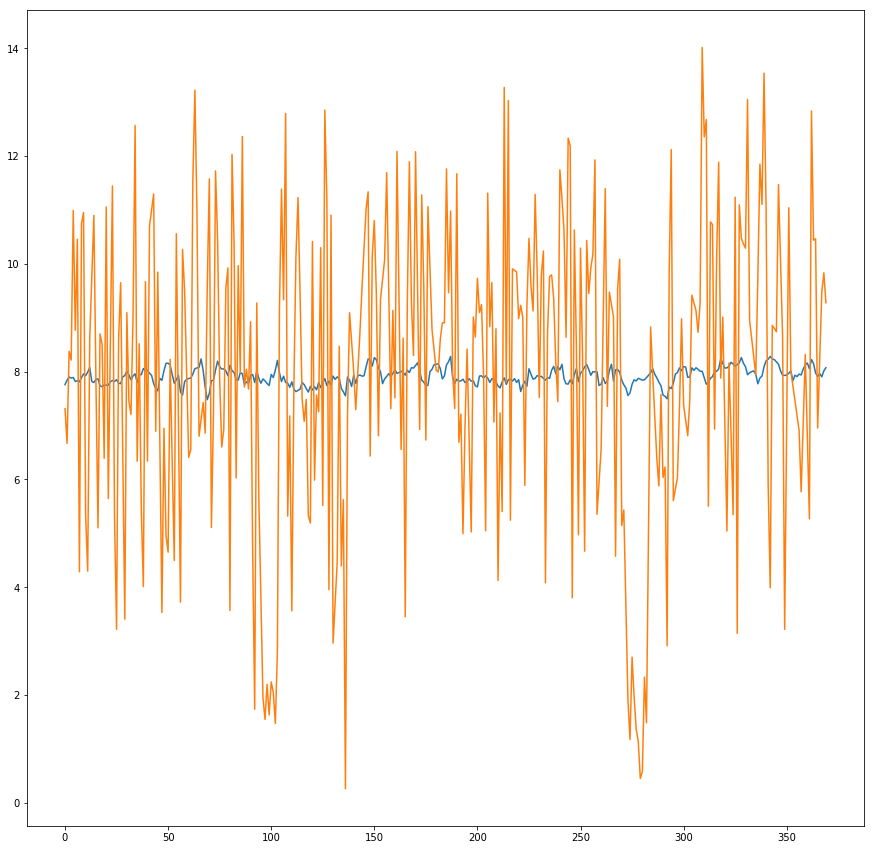

In [74]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

plt.plot(output[:,-1,1].detach().numpy())
plt.plot(target[:,-1,1].detach().numpy())